# The Boston Housing Dataset

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. 

We use this dataset to predict Median value of owner-occupied homes (MEDV) based on remaining atributes.
We are performing classical regression task. 

## Atributes:
There are 14 attributes in each case of the dataset. They are:

| Attribute | Explanation |
| :--------- | :----------- |
| CRIM | per capita crime rate by town |
| ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS | proportion of non-retail business acres per town. |
| CHAS | Charles River dummy variable (1 if tract bounds river; 0 otherwise) |
| NOX | nitric oxides concentration (parts per 10 million) |
| RM | average number of rooms per dwelling |
| AGE | proportion of owner-occupied units built prior to 1940 |
| DIS | weighted distances to five Boston employment centres |
| RAD | index of accessibility to radial highways |
| TAX | full-value property-tax rate per 10,000 dollars |
| PTRATIO | pupil-teacher ratio by town |
| B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| LSTAT | % lower status of the population |
| MEDV | Median value of owner-occupied homes in 1000's dollars |

In [30]:
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from wandb.keras import WandbCallback
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
from torch import nn
import pandas as pd
import numpy as np
import torch
import wandb

In [31]:
config = dict(
    data_flag = 'boston-housing',
    epochs = 100,
    learning_rate = 0.01,
    optimizer = 'adam',
    loss_fn = 'mse'
)

wandb.login()
wandb.init(project='boston-housing-regression', config=config)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███▇▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▂▁▁
best_epoch,29
best_val_loss,5.08502
epoch,99
loss,22.09881
val_loss,43.36726


In [32]:
print("TF: ", tf.__version__)
print("W&B: ", wandb.__version__)

TF:  2.8.0
W&B:  0.12.11


### Get dataset
Import downloaded dataset using pandas

In [33]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data_raw = pd.read_csv('./data/housing.csv', header=None, delimiter=r"\s+", names=column_names)

data = data_raw.copy()

### Split the data into train, validate and test

Split the dataset into a training set, validation set a test set, **in ratio of 80:10:10**

We will use the test set in the final evaluation of our model

In [34]:
train_data = data.sample(frac=0.9, random_state=0)
test_data = data.drop(train_data.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
sns.pairplot(train_data[['MEDV', 'NOX', 'CRIM', 'TAX', 'RM']], diag_kind='kde')

Also look at the overall statistics:

In [35]:
train_stats = train_data.describe()
train_stats.pop("MEDV")
train_stats = train_stats.transpose()
# train_stats

### Split features from labels

Separate the target value (labels), from the features. Label is the value that we will train the model to predict.

In [36]:
train_labels = train_data.pop('MEDV')
test_labels = test_data.pop('MEDV')

### Normalize the data

If we look at `train_stats` we see that our features are quite different in ranges. That's why we normalize data. It also helps to prevent model from being dependent of units of input data.
We also need to project the test dataset into the same distribution that the model has been trained on, so we normalize both train and test data.

This normalized data is what we will use to train and test the model.

In [37]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

## The Keras model

### MPL Architecture

We'll create our model layer-by-layer, so we use a Sequential model with: 

- The normalization layer for a multiple-input model
- Two hidden, non-linear, Dense layers with the ReLU (relu) activation function.
- A linear Dense single-output layer.

Explanation:

- Number of input neurons is equal to number input features, in our case it's 13.
- To add non-linearity to regression function, we use two extra hidden layers, 5 neurons each.
- Since we are interested only in price (single value), one output neuron is enought.

Shape of our network is similar to funnel, since we are trying to concentrate many information into single value.

In [3]:
def build_model(config):
  model = keras.Sequential([
    layers.Dense(13, input_shape=(13,), activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(5, activation='relu'),
    # regression - no activation function in needed the last layer
    layers.Dense(1)
  ])

  model.compile(loss=config['loss_fn'],
                optimizer=tf.optimizers.Adam(learning_rate=config['learning_rate']))
                # optimizer = tf.keras.optimizers.RMSprop(0.001))
  return model

In [39]:
model = build_model(config)

### Inspect the model

Use the .summary method to print a simple description of the model

In [ ]:
model.summary()

### Train the model

Train the model for 100 epochs, and record the training and validation accuracy in the history object as well as to WandB API

Have closer look at parameter `validation_split` that extracts validation set from trainnig samples

In [40]:
%%time

history = model.fit(
  normed_train_data, train_labels,
  epochs=config['epochs'], validation_split=0.11, verbose=0, callbacks=[WandbCallback()])


CPU times: total: 1min 11s
Wall time: 54.2 s


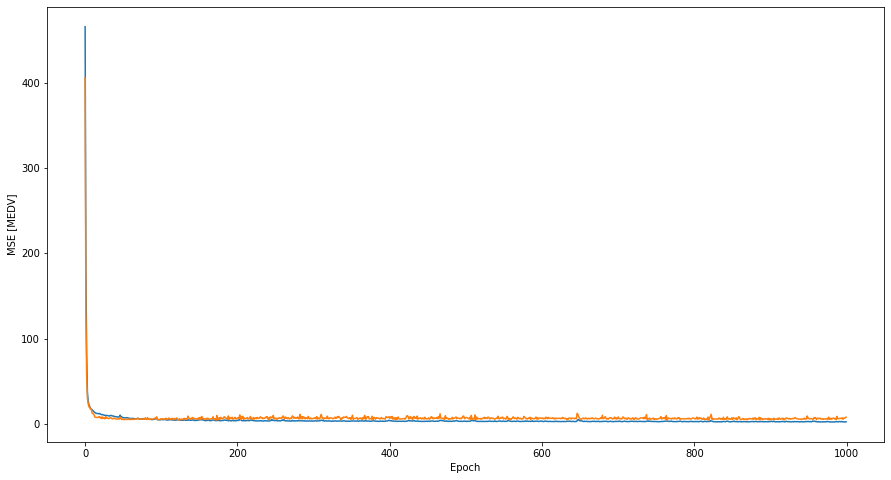

In [41]:
plt.figure(figsize=(15,8))

plt.xlabel('Epoch')
plt.ylabel('MSE [MEDV]')

plt.plot(model.history.history['loss'][:])
plt.plot(model.history.history['val_loss'][:])

### Validate model

Finally, predict MEDV values using data in the testing set and compare MAE of predicted values with mean of all house prices:

In [42]:
prediction_2d = model.predict(normed_test_data)
mae = mean_absolute_error(test_labels, prediction_2d)

print(f"We are off on average by {round(mae * 1000, 2)} US dollars, while the mean price of a house in the dataset is {round(data['MEDV'].mean() * 1000, 2)}.")

We are off on average by 1994.83 US dollars, while the mean price of a house in the dataset is 22532.81.


Visualization of predicted values compared to real ones from test set

In [1]:
prediction_1d = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, prediction_1d)
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

NameError: name 'model' is not defined

Visualization of many predictions were off by prediciton error

In [ ]:
error = prediction_1d - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
_ = plt.ylabel("Count")

Some predicted values:

## The Pytorch model


In [43]:
progres_print_rate = 10
batch_size = 1024

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(device)

cuda


In [44]:
data = data_raw.copy()

train, _test = train_test_split(data,  test_size = 0.2, shuffle=True)
test, validate = train_test_split(_test, test_size = 0.5)

train_targets = train.pop("MEDV")
test_targets = test.pop("MEDV")
validate_targets = validate.pop('MEDV')

train_stats = train.describe()
train_stats = train_stats.transpose()

In [45]:
def df_to_tensor(df):
    return torch.from_numpy(df.values).float().to(device)

In [46]:
train_dataset = TensorDataset(df_to_tensor(norm(train)), torch.Tensor([[x] for x in list(train_targets)]))
validate_dataset = TensorDataset(df_to_tensor(norm(validate)), torch.Tensor([[x] for x in list(validate_targets)]))
x_test, y_test = (df_to_tensor(norm(test)),[x for x in list(test_targets)])

train_dataloader = DataLoader(train_dataset,batch_size=batch_size)
validate_dataloader = DataLoader(validate_dataset,batch_size=batch_size)

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self,in_size, out_size):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_size, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5, out_size),
            )

    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [48]:
model = NeuralNetwork(13, 1).to(device)
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

In [49]:
# Utility function to train the model
def fit(num_epochs, model, loss_fun, optimizer, train_dl):
    # train_dl.to(device)
    # Repeat for given number of epochs
    for epoch in range(num_epochs):
        # Train with batches of data
        for xb,yb in train_dl:
            xb = xb.to(device)
            yb = yb.to(device)
            # 1. Generate predictions
            pred = model(xb)
            # 2. Calculate loss
            loss = loss_fun(pred, yb)
            # 3. Compute gradients
            loss.backward()
            # 4. Update parameters using gradients
            optimizer.step()
            # 5. Reset the gradients to zero
            optimizer.zero_grad()
            
            wandb.log({"loss": loss})
            # Optional
            wandb.watch(model)
            
        # Print the progress
        if (epoch+1) % progres_print_rate == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            validate_model(loader=validate_dataloader, model=model, loss_fun=loss_fun)
            
def validate_model(loader, model, loss_fun):                       
    running_loss = 0.0                                        
    model.eval()                                              
    with torch.no_grad():                                     
        for _, (xb, yb) in enumerate(loader):                     
            xb = xb.to(device)                        
            yb = yb.to(device)                                                                  
            outputs = model(xb)                           
            loss = loss_fun(outputs, yb)                 
            running_loss = running_loss + loss.item()         
            wandb.log({"val_loss": running_loss})
            # Optional
            wandb.watch(model)
    mean_val_loss = ( running_loss )                  
    print('Validation Loss:'  ,mean_val_loss)

In [50]:
fit(config['epochs'], model, loss_fun, optimizer, train_dataloader)

Epoch [10/1000], Loss: 607.8959
Validation Loss: 539.06201171875
Epoch [20/1000], Loss: 593.0089
Validation Loss: 523.8832397460938
Epoch [30/1000], Loss: 552.0532
Validation Loss: 480.1613464355469
Epoch [40/1000], Loss: 436.1812
Validation Loss: 357.9640808105469
Epoch [50/1000], Loss: 211.4012
Validation Loss: 148.34249877929688
Epoch [60/1000], Loss: 132.3533
Validation Loss: 133.7445526123047
Epoch [70/1000], Loss: 84.2288
Validation Loss: 84.18170166015625
Epoch [80/1000], Loss: 61.5814
Validation Loss: 65.39817810058594
Epoch [90/1000], Loss: 43.9441
Validation Loss: 58.13558578491211
Epoch [100/1000], Loss: 32.6403
Validation Loss: 48.28141403198242
Epoch [110/1000], Loss: 26.7489
Validation Loss: 44.73224639892578
Epoch [120/1000], Loss: 24.1814
Validation Loss: 43.0447883605957
Epoch [130/1000], Loss: 22.9991
Validation Loss: 41.25254821777344
Epoch [140/1000], Loss: 22.1506
Validation Loss: 40.182064056396484
Epoch [150/1000], Loss: 21.3749
Validation Loss: 38.82241058349609

In [51]:
#Converting predictions from tensor objects into a list
y_pred_test = model(x_test)
y_pred_test = [y_pred_test[x].item() for x in range(len(y_pred_test))]

# Comparing Actual and predicted values
df = {}
df['Actual Prices'] = np.multiply(y_test,1000)
df['Predicted Prices'] = np.multiply(y_pred_test,1000) 
df = pd.DataFrame(df)
print(df)

    Actual Prices  Predicted Prices
0         21200.0      19997.655869
1         28600.0      30208.589554
2         42300.0      42887.157440
3         18500.0      16825.113297
4         10900.0      11382.355690
5         41300.0      37764.781952
6         38700.0      42829.227448
7         23800.0      17735.456467
8         24400.0      21774.179459
9         50000.0      49300.884247
10        21200.0      19335.523605
11        21700.0      19938.844681
12        21400.0      22695.222855
13         7200.0      13672.867775
14        20300.0      21249.742508
15        22600.0      21082.635880
16        21200.0      22712.125778
17        18400.0      16243.204117
18        15200.0      18329.393387
19        50000.0      34580.669403
20        23200.0      14433.699608
21        14500.0      16197.290421
22        14600.0      17403.944016
23        21100.0      20626.806259
24        18400.0      14210.900307
25        24300.0      28746.217728
26        19900.0      18944

### Validate model

Finally, predict MEDV values using data in the testing set and compare MAE of predicted values with mean of all house prices:

In [52]:
# Let's check how much we are off on average
# y_pred = model(df_to_tensor(norm(train)))
mae = mean_absolute_error(df['Actual Prices'], df['Predicted Prices'])

print(f"We are off on average by {round(mae, 2)} US dollars, while the mean price of a house in the dataset is {round(test_targets.mean()*1000, 2)}.")

We are off on average by 2936.28 US dollars, while the mean price of a house in the dataset is 22684.31.


Visualization of predicted values compared to real ones from test set

In [ ]:
prediction_1d = y_pred_test.flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, prediction_1d)
plt.xlabel('True Values [MEDV]')
plt.ylabel('Predictions [MEDV]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Visualization of many predictions were off by prediciton error

In [ ]:
error = prediction_1d - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MEDV]")
_ = plt.ylabel("Count")